In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.examples.tutorials. mnist import input_data

In [16]:
mnist=input_data.read_data_sets("MNIST_data/")
trX, trY, teX, teY= mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [20]:
h_in, w_in = 28, 28   #image size height and width
k=3    #kernel size
p=2    # pool
s=2    # strides in maxpool
filters = {1:32, 2:32, 3: 16}

activation_fn= tf.nn.relu

#height and width for second encoder/ decoder
h_l2, w_l2 = int(np.ceil(float(h_in) / float(s))), int(np.ceil(float(w_in) / float(s)))

#height and width  for third encoder / decoder
h_l3, w_l3 = int(np.ceil(float(h_l2) / float(s))), int(np.ceil(float(w_l2) / float(s)))




In [21]:
x_noisy = tf.placeholder(tf.float32, (None, h_in, w_in, 1), name = 'inputs')
X= tf.placeholder(tf.float32, (None, h_in, w_in, 1), name = 'targets')


In [36]:
# Build the encoder amd decoder networks
### Encoder 
conv1 = tf.layers.conv2d(x_noisy, filters[1], 
                         (k,k), padding = 'same',
                         activation=activation_fn)

print(np.shape(conv1))
#output size h_in * w_in * filters[1]
maxpool1= tf.layers.max_pooling2d(conv1, (p,p), (s,s), 
                           padding='same')


print(np.shape(maxpool1))
#output size h_l2 * w_l2 * filters[2]
conv2 = tf.layers.conv2d(maxpool1, filters[2], 
                        (k,k), padding= 'same', 
                        activation = activation_fn)

print(np.shape(conv2))
maxpool2 = tf.layers.max_pooling2d(conv2, (p,p), (s,s), 
                              padding= 'same')

#output size h_l3 * w_l3 * filters[3]
print(np.shape(maxpool2))
conv3 = tf.layers.conv2d(maxpool2, filters[3], 
                         (k,k), padding = 'same',
                         activation= activation_fn)

# now 4 * 4 * 16
encoded = tf.layers.max_pooling2d(conv3, (p,p), (s,s),
                              padding  = 'same')

print(np.shape(encoded))
### Decoder

upsample1 = tf.image.resize_nearest_neighbor(encoded, (h_l3, w_l3))
print(np.shape(upsample1))
    
    #output size h_l3 * w_l3 * filters[3]
    
    
conv4= tf.layers.conv2d(upsample1, filters[3],
                        (k,k), padding = 'same', 
                        activation = activation_fn)


print(np.shape(conv4))

upsample2 = tf.image.resize_nearest_neighbor(conv4,(h_l2, w_l2))

print(np.shape(upsample2))

#output size h_l2 * w_l2 * filters[2]

conv5= tf.layers.conv2d(upsample2, filters[2],
                        (k,k), padding = 'same', 
                        activation = activation_fn)

print(np.shape(conv5))

upsample3 = tf.image.resize_nearest_neighbor(conv5,(h_in, w_in))


#output size h_in * w_in * filters[2]


conv6= tf.layers.conv2d(upsample3, filters[1],
                        (k,k), padding = 'same', 
                        activation = activation_fn)

#output size h_in * w_in * filters[1]

logits = tf.layers.conv2d(conv6, 1,
                          (k,k), padding = 'same',
                          activation = None)

#output size h_in * w_in * 1

decoded = tf.nn.sigmoid(logits, name = 'decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = X, logits = logits)
cost = tf.reduce_mean(loss)
opt= tf.train.AdamOptimizer(0.001).minimize(cost)





(?, 28, 28, 32)
(?, 14, 14, 32)
(?, 14, 14, 32)
(?, 7, 7, 32)
(?, 4, 4, 16)
(?, 7, 7, 16)
(?, 7, 7, 16)
(?, 14, 14, 16)
(?, 14, 14, 32)


In [41]:
epochs = 10
batch_size = 100
# Set how much noise we're adding to the MNIST images
noise_factor = 0.5
sess = tf.Session()

sess.run(tf.global_variables_initializer())
err= []
for i in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size) 
        # Get images from the batch
        
        imgs= batch[0].reshape((-1, h_in, w_in, 1))
        
        #Add random noise to the input images
        
        noisy_imgs = imgs + noise_factor*np.random.randn(*imgs.shape)
        #Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0. , 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict= {x_noisy: noisy_imgs, X: imgs})
        
        err.append(batch_cost)
        
        if ii % 100 == 0:
            print("Epochs {0}/ {1} ... Training loss {2}".format(i, epochs, batch_cost))

Epochs 0/ 10 ... Training loss 0.6882572174072266
Epochs 0/ 10 ... Training loss 0.22271628677845
Epochs 0/ 10 ... Training loss 0.18984921276569366
Epochs 0/ 10 ... Training loss 0.17915795743465424
Epochs 0/ 10 ... Training loss 0.1680791825056076
Epochs 0/ 10 ... Training loss 0.15756572782993317
Epochs 1/ 10 ... Training loss 0.15571585297584534
Epochs 1/ 10 ... Training loss 0.143027201294899
Epochs 1/ 10 ... Training loss 0.1442839652299881
Epochs 1/ 10 ... Training loss 0.14012525975704193
Epochs 1/ 10 ... Training loss 0.13768638670444489
Epochs 1/ 10 ... Training loss 0.1334240883588791
Epochs 2/ 10 ... Training loss 0.13463379442691803
Epochs 2/ 10 ... Training loss 0.13591083884239197
Epochs 2/ 10 ... Training loss 0.1377168744802475
Epochs 2/ 10 ... Training loss 0.13509385287761688
Epochs 2/ 10 ... Training loss 0.13395032286643982
Epochs 2/ 10 ... Training loss 0.13347020745277405
Epochs 3/ 10 ... Training loss 0.12656033039093018
Epochs 3/ 10 ... Training loss 0.12793217

Text(0, 0.5, 'cross entropy loss')

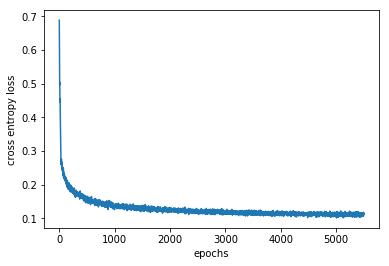

In [42]:
import matplotlib.pyplot as plt
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('cross entropy loss')

In [ ]:
figs, axes = plt.subplots(nrows=2, ncols=10, sharex = True, sharey=True, figsize = (20,4))
in_imgs = mnist.test.images[:10]

noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)
reconstructed = sess.run(decoded, feed_dict = {x_noisy:noisy_imgs.reshape((10,28,28,1))})
for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28,28)), cmap = 'Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [6]:
n_classes= 10
batch_size= 100

In [7]:
x=tf.placeholder(tf.float32, [None, 784], name= 'InputData')
y=tf.placeholder(tf.float32, [None, 10], name= 'LabelData')


In [8]:
def conv2d(input, name, kshape, strides= [1,1,1,1]):
    with tf.name_scope(name):
        W= tf.Variable(name = 'w_' + name,
                          shape =kshape)

In [13]:
tf.nn.conv2d_transpose?

In [14]:
tf.nn.conv2d?

In [22]:
tf.stack?
tf.layers.conv2d?